# <center> <a href="https://datatopics.worldbank.org/world-development-indicators/">Working with World Development Indicators (WDI)</a></center>

<center><a href="https://data.worldbank.org/indicator"> <img src="https://raw.githubusercontent.com/SMU-Econ-Growth/EconGrowthUG-Notebooks/main/pics/logo-wb-header-en.svg" alt="WDI" width=1000/></a>  </center>

* World Development Indicators (WDI) is the World Bank’s premier compilation of cross-country comparable data on development.

* Widely used for analysis

* Free and easy to access

* Lot's of variables are available, from multiple sources that have been collected by the WB. 

* If you check [their website](https://data.worldbank.org/) you can see more information on them, also identify and search the variables you may want to focus on. 

# Setup

# Import Modules and set Paths

In [1]:
# Basic Packages
from __future__ import division
import os
from datetime import datetime

# Web & file access
import requests
import io

# Import display options for showing websites
from IPython.display import IFrame, HTML

In [2]:
# Plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

%pylab --no-import-all
%matplotlib inline

import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_context("talk")

import plotly.express as px
import plotly.graph_objects as go

from plotnine import ggplot, geom_point, aes, stat_smooth, facet_wrap
# Next line can import all of plotnine, but may overwrite things? Better import each function/object you need
#from plotnine import *

Using matplotlib backend: <object object at 0x18828d430>
%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [3]:
# Data
import pandas as pd
import numpy as np
from pandas_datareader import data, wb

# GIS & maps
import geopandas as gpd
gp = gpd
import georasters as gr
import geoplot as gplt
import geoplot.crs as gcrs
import mapclassify as mc
import textwrap

In [4]:
# Data Munging
from itertools import product, combinations
import difflib
import pycountry
import geocoder
from geonamescache.mappers import country
mapper = country(from_key='name', to_key='iso3')
mapper2 = country(from_key='iso3', to_key='iso')
mapper3 = country(from_key='iso3', to_key='name')

# Regressions & Stats
from scipy.stats import norm
import statsmodels.formula.api as smf
from stargazer.stargazer import Stargazer, LineLocation

In [5]:
# Paths
pathout = './data/'

if not os.path.exists(pathout):
    os.mkdir(pathout)
    
pathgraphs = './graphs/'
if not os.path.exists(pathgraphs):
    os.mkdir(pathgraphs)

In [6]:
currentYear = datetime.now().year
year = min(2020, currentYear-2)

# Getting WDI data from the World Bank

* [Head over to the WDI Indicator website](https://data.worldbank.org/indicator) 

* Search for the variable you are interested in

    (e.g., **GDP per capita, PPP (constant 2017 international $)**)

* The link will become [https://data.worldbank.org/indicator/NY.GDP.PCAP.PP.KD](https://data.worldbank.org/indicator/NY.GDP.PCAP.PP.KD)

    (if feasible it will display a figure)

In [7]:
url = 'https://data.worldbank.org/share/widget?indicators=NY.GDP.PCAP.PP.KD'
IFrame(url, width=500, height=300)

# Downloading the data

* Suboptimal: Download from the website 

    (Not best approach, since you need to do it for every variable every time data is updated)

* Using API: Let's instead use the wonderful [pandas-data-reader package](https://pandas-datareader.readthedocs.io/en/latest/index.html)

# <font size="30">WDI with</font>
# <center> <a href="https://pandas-datareader.readthedocs.io/en/latest/index.html"><img src="https://pandas-datareader.readthedocs.io/en/latest/_static/pandas-datareader-plain.svg" alt="pandas-data-reader" width=700/></a></center>

In [8]:
url = 'https://pandas-datareader.readthedocs.io/en/latest/remote_data.html#remote-data-wb'
IFrame(url, width=800, height=400)

## Steps

1. Import **pandas-data-reader**
```python
from pandas_datareader import data, wb
```

2. Download basic country/aggregates information
```python
wbcountries = wb.get_countries()
```

3. Clean up
```python
# If you want to keep aggregate data for regions or world comment out next line
wbcountries = wbcountries.loc[wbcountries.region.isin(['Aggregates'])==False].reset_index(drop=True)
wbcountries['name'] = wbcountries.name.str.strip()
wbcountries['incomeLevel'] = wbcountries['incomeLevel'].str.title()
wbcountries.loc[wbcountries.iso3c=='VEN', 'incomeLevel'] = 'Upper Middle Income'
```

In [9]:
wbcountries = wb.get_countries()
wbcountries = wbcountries.loc[wbcountries.region.isin(['Aggregates'])==False].reset_index(drop=True)
wbcountries['name'] = wbcountries.name.str.strip()
wbcountries['incomeLevel'] = wbcountries['incomeLevel'].str.title()
wbcountries.loc[wbcountries.iso3c=='VEN', 'incomeLevel'] = 'Upper Middle Income'

4. Get Indicators of interest

* Few and varied indicators of interest: 
    
    Search for the variable on the WDI Indicator website (as explained above)
        
    (e.g., [https://data.worldbank.org/indicator/NY.GDP.PCAP.PP.KD](https://data.worldbank.org/indicator/NY.GDP.PCAP.PP.KD))
        
    Add the indicator's name into a list of indicators in **Python**

    (i.e., everything that comes after **https://data.worldbank.org/indicator/**. E.g., `NY.GDP.PCAP.PP.KD`)
        

```python
wdi_indicators = ['NY.GDP.PCAP.PP.KD', 'NY.GDP.PCAP.KD', 'SL.GDP.PCAP.EM.KD', 'SP.POP.GROW', 'SP.POP.TOTL', 'SP.DYN.WFRT', 'SP.DYN.TFRT.IN']
```

In [10]:
wdi_indicators = ['NY.GDP.PCAP.PP.KD', 'NY.GDP.PCAP.KD', 'SL.GDP.PCAP.EM.KD', 'SP.POP.GROW', 'SP.POP.TOTL', 'SP.DYN.WFRT', 'SP.DYN.TFRT.IN']

* Many related indicators or mass search

    (e.g., search for all variables containing the word *population*)

```python
popvars = wb.search(string='population')
```
    
This returns a dataframe, where the column `id` has the IDs for the indicators

In [11]:
popvars = wb.search(string='population')
popvars.head()

id                                               name unit                           source                                         sourceNote  \
24     1.1_ACCESS.ELECTRICITY.TOT      Access to electricity (% of total population)            Sustainable Energy for All  Access to electricity is the percentage of pop...   
39   1.2_ACCESS.ELECTRICITY.RURAL      Access to electricity (% of rural population)            Sustainable Energy for All  Access to electricity is the percentage of rur...   
40   1.3_ACCESS.ELECTRICITY.URBAN      Access to electricity (% of urban population)            Sustainable Energy for All  Access to electricity is the percentage of tot...   
164            2.1_ACCESS.CFT.TOT  Access to Clean Fuels and Technologies for coo...            Sustainable Energy for All                                                      
195             3.11.01.01.popcen                                  Population census       Statistical Capacity Indicators  Population censuses collect data on the size, ...   

                                    sourceOrganization topics  
24   b'World Bank Global Electrification Database 2...         
39   b'World Bank Global Electrification Database 2...         
40   b'World Bank Global Electrification Database 2...         
164                                                b''         
195  b'World Bank Microdata library. Original sourc...

5. Download data for selected indicators, years, and countries

```python
wdi = wb.download(indicator=wdi_indicators,
                  country=list_of_countries_ISO_A2_codes, 
                  start=start_year, 
                  end=end_year)
```

6. Clean up and process data
```python
wdi = wdi.reset_index()
wdi['year'] = wdi.year.astype(int)
```

In [12]:
wdi = wb.download(indicator=wdi_indicators, country=wbcountries.iso2c.values, start=1950, end=year)
wdi = wdi.reset_index()
wdi['year'] = wdi.year.astype(int)
wdi['gdp_pc'] = wdi['NY.GDP.PCAP.PP.KD']
wdi['ln_gdp_pc'] = wdi['NY.GDP.PCAP.PP.KD'].apply(np.log)
wdi['ln_pop'] = wdi['SP.POP.TOTL'].apply(np.log)
wdi.head()

/Users/ozak/anaconda3/envs/EconGrowthUG-Builds/lib/python3.9/site-packages/pandas_datareader/wb.py:592: UserWarning: Non-standard ISO country codes: JG, XK


country  year  NY.GDP.PCAP.PP.KD  NY.GDP.PCAP.KD  SL.GDP.PCAP.EM.KD  SP.POP.GROW  SP.POP.TOTL  SP.DYN.WFRT  SP.DYN.TFRT.IN        gdp_pc  ln_gdp_pc     ln_pop
0   Aruba  2020       29563.756955    23026.332866                NaN     0.428017     106766.0          NaN           1.901  29563.756955  10.294304  11.578395
1   Aruba  2019       38221.117314    29769.293907                NaN     0.437415     106310.0          NaN           1.901  38221.117314  10.551143  11.574115
2   Aruba  2018       39206.356147    30536.667193                NaN     0.459266     105846.0          NaN           1.896  39206.356147  10.576594  11.569740
3   Aruba  2017       38893.960556    30293.351539                NaN     0.471874     105361.0          NaN           1.886  38893.960556  10.568594  11.565148
4   Aruba  2016       37046.877414    28854.713299                NaN     0.502860     104865.0          NaN           1.872  37046.877414  10.519939  11.560429

7. Add other WB data from the ``wbcountries`` dataframe
```python
wdi = wbcountries.merge(wdi, left_on='name', right_on='country')
```

In [13]:
wdi = wbcountries.merge(wdi, left_on='name', right_on='country')
wdi.head()

iso3c iso2c   name                      region adminregion  incomeLevel     lendingType capitalCity  longitude  latitude  ... NY.GDP.PCAP.PP.KD  NY.GDP.PCAP.KD  \
0   ABW    AW  Aruba  Latin America & Caribbean               High Income  Not classified  Oranjestad   -70.0167   12.5167  ...      29563.756955    23026.332866   
1   ABW    AW  Aruba  Latin America & Caribbean               High Income  Not classified  Oranjestad   -70.0167   12.5167  ...      38221.117314    29769.293907   
2   ABW    AW  Aruba  Latin America & Caribbean               High Income  Not classified  Oranjestad   -70.0167   12.5167  ...      39206.356147    30536.667193   
3   ABW    AW  Aruba  Latin America & Caribbean               High Income  Not classified  Oranjestad   -70.0167   12.5167  ...      38893.960556    30293.351539   
4   ABW    AW  Aruba  Latin America & Caribbean               High Income  Not classified  Oranjestad   -70.0167   12.5167  ...      37046.877414    28854.713299   

   SL.GDP.PCAP.EM.KD  SP.POP.GROW  SP.POP.TOTL  SP.DYN.WFRT  SP.DYN.TFRT.IN        gdp_pc  ln_gdp_pc     ln_pop  
0                NaN     0.428017     106766.0          NaN           1.901  29563.756955  10.294304  11.578395  
1                NaN     0.437415     106310.0          NaN           1.901  38221.117314  10.551143  11.574115  
2                NaN     0.459266     105846.0          NaN           1.896  39206.356147  10.576594  11.569740  
3                NaN     0.471874     105361.0          NaN           1.886  38893.960556  10.568594  11.565148  
4                NaN     0.502860     104865.0          NaN           1.872  37046.877414  10.519939  11.560429  

[5 rows x 22 columns]

# Regression Analysis with 
<center><a href="statsmodels"><img src="https://www.statsmodels.org/stable/_images/statsmodels-logo-v2-horizontal.svg" alt="statsmodels" width=700/></a></center>

In [14]:
url = 'https://www.statsmodels.org/stable/index.html'
IFrame(url, width=800, height=400)

## Linear Regressions using OLS 

It is very easy to run a regression in **statsmodels**. 

We only need

* Data in a **pandas** dataframe

* An equation we want to estimate

Equations are strings of the form 
```python
'dependent_variable ~ indep_var_1 + function(indep_var2) + C(indep_var3)'
```

where:
* `dependent_variable` is the outcome variable of interest
* `indep_var_1` is the first independent variable        
* `function(indep_var2)` is a function of another independent variable (if needed)      
* `C(indep_var3)` defines fixed-effects/dummies based on categories given in indep_var3

## Simple Regression of Log[GDP pc] and Latitude

In [15]:
dffig = wdi.loc[wdi.year==year]\
            .dropna(subset=['ln_gdp_pc', 'latitude', 'ln_pop'])\
            .sort_values(by='region').reset_index()

In [85]:
mod = smf.ols(formula='ln_gdp_pc ~ latitude', data=dffig, missing='drop').fit()

In [86]:
mod.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Ordinary least squares
=================================================================
Model:              OLS              Adj. R-squared:     0.230   
Dependent Variable: ln_gdp_pc        AIC:                544.5117
Date:               2022-10-27 14:45 BIC:                551.0057
No. Observations:   190              Log-Likelihood:     -270.26 
Df Model:           1                F-statistic:        57.42   
Df Residuals:       188              Prob (F-statistic): 1.55e-12
R-squared:          0.234            Scale:              1.0177  
-------------------------------------------------------------------
             Coef.    Std.Err.      t      P>|t|    [0.025   0.975]
-------------------------------------------------------------------
Intercept    8.9496     0.0919   97.3483   0.0000   8.7682   9.1309
latitude     0.0230     0.0030    7.5777   0.0000   0.0170   0.0290
-----------------------------------------------------------------
Omnibus:              0.797        Durbin-Watson:           1.698
Prob(Omnibus):        0.671        Jarque-Bera (JB):        0.853
Skew:                 0.002        Prob(JB):                0.653
Kurtosis:             2.672        Condition No.:           38   
=================================================================

"""

## Plot Data and OLS Regression Predictions

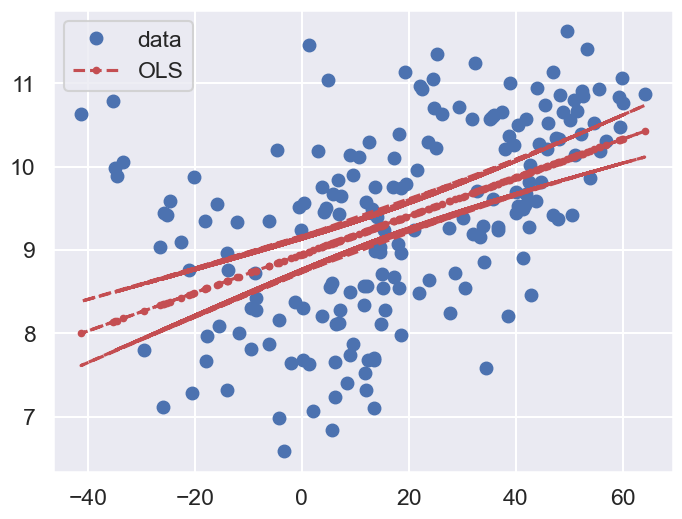

In [18]:
pred_ols = mod.get_prediction()
iv_l = pred_ols.summary_frame()["mean_ci_lower"]
iv_u = pred_ols.summary_frame()["mean_ci_upper"]

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(dffig.latitude, dffig.ln_gdp_pc, "o", label="data")
ax.plot(dffig.latitude, mod.fittedvalues, "r--.", label="OLS")
ax.plot(dffig.latitude, iv_u, "r--")
ax.plot(dffig.latitude, iv_l, "r--")
ax.legend(loc="best")

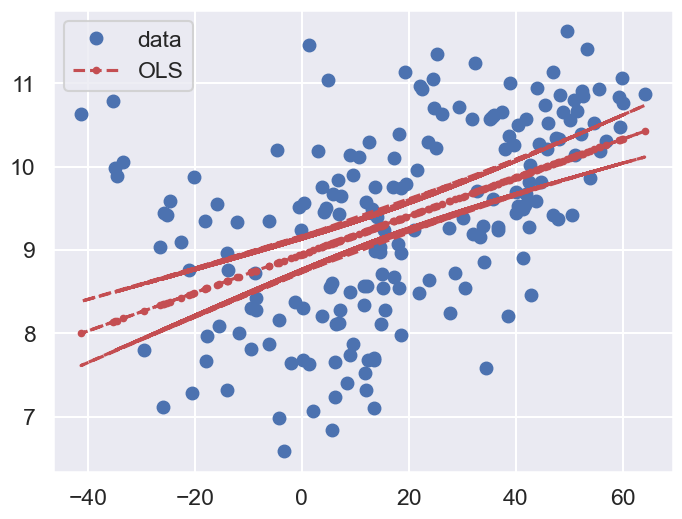

In [19]:
fig

## Simple Regression of Log[GDP pc] and Latitude accounting for WB region dummies

In [20]:
mod2 = smf.ols(formula='ln_gdp_pc ~ latitude + C(region)', data=dffig, missing='drop').fit()

In [21]:
mod2.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                            Results: Ordinary least squares
=======================================================================================
Model:                      OLS                     Adj. R-squared:            0.495   
Dependent Variable:         ln_gdp_pc               AIC:                       470.1465
Date:                       2022-10-27 11:32        BIC:                       496.1227
No. Observations:           190                     Log-Likelihood:            -227.07 
Df Model:                   7                       F-statistic:               27.47   
Df Residuals:               182                     Prob (F-statistic):        1.54e-25
R-squared:                  0.514                   Scale:                     0.66723 
---------------------------------------------------------------------------------------
                                         Coef.  Std.Err.    t    P>|t|   [0.025  0.975]
---------------------------------------------------------------------------------------
Intercept                                9.3596   0.1482 63.1635 0.0000  9.0673  9.6520
C(region)[T.Europe & Central Asia]       0.8276   0.2643  3.1314 0.0020  0.3061  1.3490
C(region)[T.Latin America & Caribbean ]  0.2065   0.2016  1.0243 0.3071 -0.1913  0.6042
C(region)[T.Middle East & North Africa]  0.5115   0.2654  1.9273 0.0555 -0.0122  1.0352
C(region)[T.North America]               1.5940   0.5155  3.0919 0.0023  0.5768  2.6112
C(region)[T.South Asia]                 -0.6446   0.3334 -1.9337 0.0547 -1.3024  0.0131
C(region)[T.Sub-Saharan Africa ]        -1.2574   0.1917 -6.5578 0.0000 -1.6357 -0.8791
latitude                                 0.0010   0.0043  0.2268 0.8208 -0.0076  0.0095
---------------------------------------------------------------------------------------
Omnibus:                      1.017               Durbin-Watson:                  2.215
Prob(Omnibus):                0.601               Jarque-Bera (JB):               1.096
Skew:                         0.168               Prob(JB):                       0.578
Kurtosis:                     2.842               Condition No.:                  286  
=======================================================================================

"""

## Simple Regression of Log[GDP pc] and absolute latitude, accounting for WB region dummies

In [22]:
mod3 = smf.ols(formula='ln_gdp_pc ~ np.abs(latitude) + C(region)', data=dffig, missing='drop').fit()

In [23]:
mod3.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                            Results: Ordinary least squares
=======================================================================================
Model:                      OLS                     Adj. R-squared:            0.520   
Dependent Variable:         ln_gdp_pc               AIC:                       460.5396
Date:                       2022-10-27 11:32        BIC:                       486.5158
No. Observations:           190                     Log-Likelihood:            -222.27 
Df Model:                   7                       F-statistic:               30.25   
Df Residuals:               182                     Prob (F-statistic):        1.73e-27
R-squared:                  0.538                   Scale:                     0.63434 
---------------------------------------------------------------------------------------
                                         Coef.  Std.Err.    t    P>|t|   [0.025  0.975]
---------------------------------------------------------------------------------------
Intercept                                9.0090   0.1838 49.0269 0.0000  8.6464  9.3715
C(region)[T.Europe & Central Asia]       0.2314   0.2763  0.8376 0.4034 -0.3137  0.7766
C(region)[T.Latin America & Caribbean ]  0.2287   0.1965  1.1635 0.2462 -0.1591  0.6165
C(region)[T.Middle East & North Africa]  0.2693   0.2514  1.0712 0.2855 -0.2267  0.7654
C(region)[T.North America]               1.1738   0.5036  2.3308 0.0209  0.1801  2.1674
C(region)[T.South Asia]                 -0.7494   0.3183 -2.3541 0.0196 -1.3775 -0.1213
C(region)[T.Sub-Saharan Africa ]        -1.1397   0.1894 -6.0178 0.0000 -1.5134 -0.7660
np.abs(latitude)                         0.0208   0.0068  3.0811 0.0024  0.0075  0.0341
---------------------------------------------------------------------------------------
Omnibus:                      3.219               Durbin-Watson:                  2.238
Prob(Omnibus):                0.200               Jarque-Bera (JB):               2.974
Skew:                         0.305               Prob(JB):                       0.226
Kurtosis:                     3.064               Condition No.:                  283  
=======================================================================================

"""

## Simple Regression of Log[GDP pc] and Log[absolute latitude] accounting for WB region dummies

In [24]:
mod4 = smf.ols(formula='ln_gdp_pc ~ np.log(np.abs(latitude)) + C(region)', data=dffig, missing='drop').fit()

In [25]:
mod4.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                            Results: Ordinary least squares
=======================================================================================
Model:                      OLS                     Adj. R-squared:            0.497   
Dependent Variable:         ln_gdp_pc               AIC:                       469.4181
Date:                       2022-10-27 11:32        BIC:                       495.3943
No. Observations:           190                     Log-Likelihood:            -226.71 
Df Model:                   7                       F-statistic:               27.68   
Df Residuals:               182                     Prob (F-statistic):        1.09e-25
R-squared:                  0.516                   Scale:                     0.66468 
---------------------------------------------------------------------------------------
                                         Coef.  Std.Err.    t    P>|t|   [0.025  0.975]
---------------------------------------------------------------------------------------
Intercept                                9.2090   0.2315 39.7749 0.0000  8.7522  9.6658
C(region)[T.Europe & Central Asia]       0.7798   0.2140  3.6434 0.0004  0.3575  1.2020
C(region)[T.Latin America & Caribbean ]  0.1984   0.2014  0.9851 0.3259 -0.1990  0.5957
C(region)[T.Middle East & North Africa]  0.4772   0.2510  1.9012 0.0589 -0.0180  0.9725
C(region)[T.North America]               1.5506   0.5009  3.0956 0.0023  0.5622  2.5389
C(region)[T.South Asia]                 -0.6582   0.3253 -2.0231 0.0445 -1.3001 -0.0163
C(region)[T.Sub-Saharan Africa ]        -1.2359   0.1921 -6.4327 0.0000 -1.6150 -0.8568
np.log(np.abs(latitude))                 0.0636   0.0735  0.8664 0.3874 -0.0813  0.2086
---------------------------------------------------------------------------------------
Omnibus:                      1.172               Durbin-Watson:                  2.224
Prob(Omnibus):                0.557               Jarque-Bera (JB):               1.216
Skew:                         0.185               Prob(JB):                       0.544
Kurtosis:                     2.871               Condition No.:                  29   
=======================================================================================

"""

# Producing a nice table with **stargazer**

In [26]:
url = 'https://nbviewer.org/github/mwburke/stargazer/blob/master/examples.ipynb'
IFrame(url, width=800, height=400)

## Add the estimated models to **Stargazer**

In [27]:
stargazer = Stargazer([mod, mod2, mod3, mod4])

In [28]:
stargazer.significant_digits(2)
stargazer.show_degrees_of_freedom(False)
#stargazer.dep_var_name = ''
stargazer.dependent_variable = ' Log[GDP per capita (' + str(year) + ')]'
stargazer.custom_columns(['Latitude', 'Abs(Latitude)', 'Log[Abs(Latitude)]'], [2, 1, 1])
#stargazer.show_model_numbers(False)
stargazer.rename_covariates({'latitude':'Latitude', 
                             'np.abs(latitude)':'Absolute Latitude',
                             'np.log(np.abs(latitude))':'Log[Absolute Latitude]',})
stargazer.add_line('WB Region FE', ['No', 'Yes', 'Yes', 'Yes'], LineLocation.FOOTER_TOP)
stargazer.covariate_order(['latitude', 'np.abs(latitude)', 'np.log(np.abs(latitude))'])
stargazer.cov_spacing = 2

In [29]:
stargazer

## To show the table
```python
HTML(stargazer.render_html())
```

In [30]:
HTML(stargazer.render_html())

## To export the table to another file

In [31]:
file_name = "table.html" #Include directory path if needed
html_file = open(pathgraphs + file_name, "w" ) #This will overwrite an existing file
html_file.write( stargazer.render_html() )
html_file.close()

In [32]:
url = pathgraphs + 'table.html'
url = 'https://smu-econ-growth.github.io/EconGrowthUG-Slides-Working-with-WDI/table.html'
IFrame(url, width=500, height=300)

# Plotting WDI data

## Many options
* Since the data is a **pandas** dataframe, we could just use its functions as [we did previously](./Intro-Data-Analysis-Pandas.ipynb)
* Use the **[seaborn](https://seaborn.pydata.org/index.html)** package
* Use the **[plotly](https://plotly.com/python/)** package
* Use the **[plotnine](https://plotnine.readthedocs.io/en/stable/)** package

# Plots with 
<center><a href="https://seaborn.pydata.org/index.html#"><img src="https://raw.githubusercontent.com/SMU-Econ-Growth/EconGrowthUG-Notebooks/main/pics/logo-wide-lightbg.svg" alt="seaborn" width=700/></a></center>

In [33]:
url = 'https://seaborn.pydata.org/examples/index.html'
IFrame(url, width=800, height=400)

Let's create a [Scatterplot with varying point sizes and hues](https://seaborn.pydata.org/examples/scatter_bubbles.html) that plots the latitude and Log[GDP per capita] of each country and uses its log-population and the WB region in the last available year as the size and hue.

## Using [`relplot`](https://seaborn.pydata.org/generated/seaborn.relplot.html#seaborn.relplot)

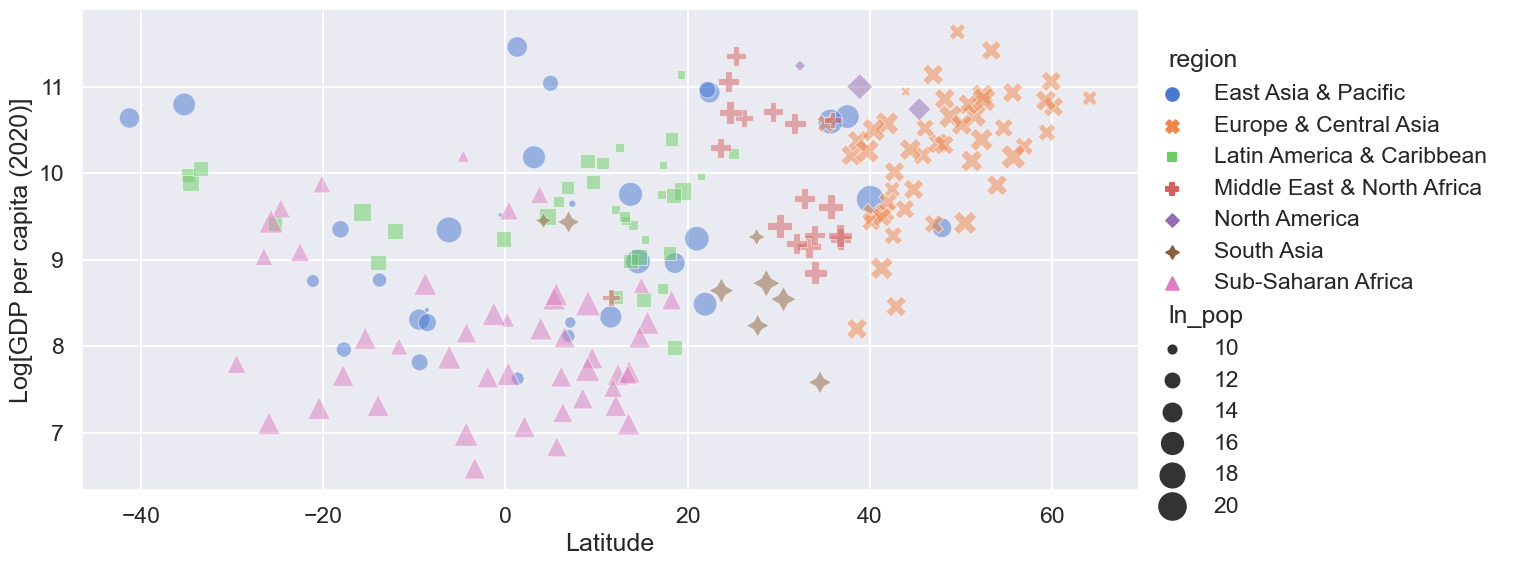

In [34]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_context("talk")

g = sns.relplot(x="latitude", 
                y="ln_gdp_pc", 
                data=dffig,
                hue="region",
                hue_order = dffig.region.drop_duplicates().sort_values(),
                style="region",
                style_order = dffig.region.drop_duplicates().sort_values(),
                size="ln_pop",
                sizes=(10, 400), 
                alpha=.5, 
                height=6,
                aspect=2,
                palette="muted",
               )
g.set_axis_labels('Latitude', 'Log[GDP per capita (' + str(year) + ')]')

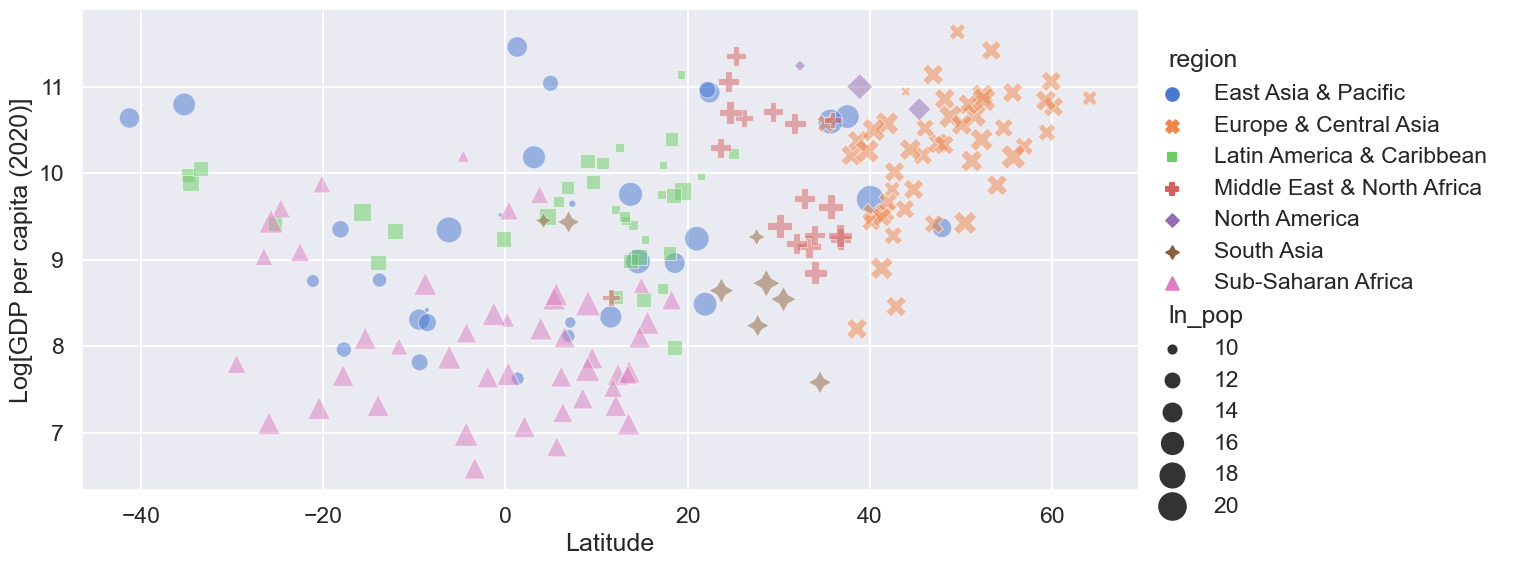

In [35]:
g.fig

# Using [`scatterplot`](https://seaborn.pydata.org/generated/seaborn.scatterplot.html)

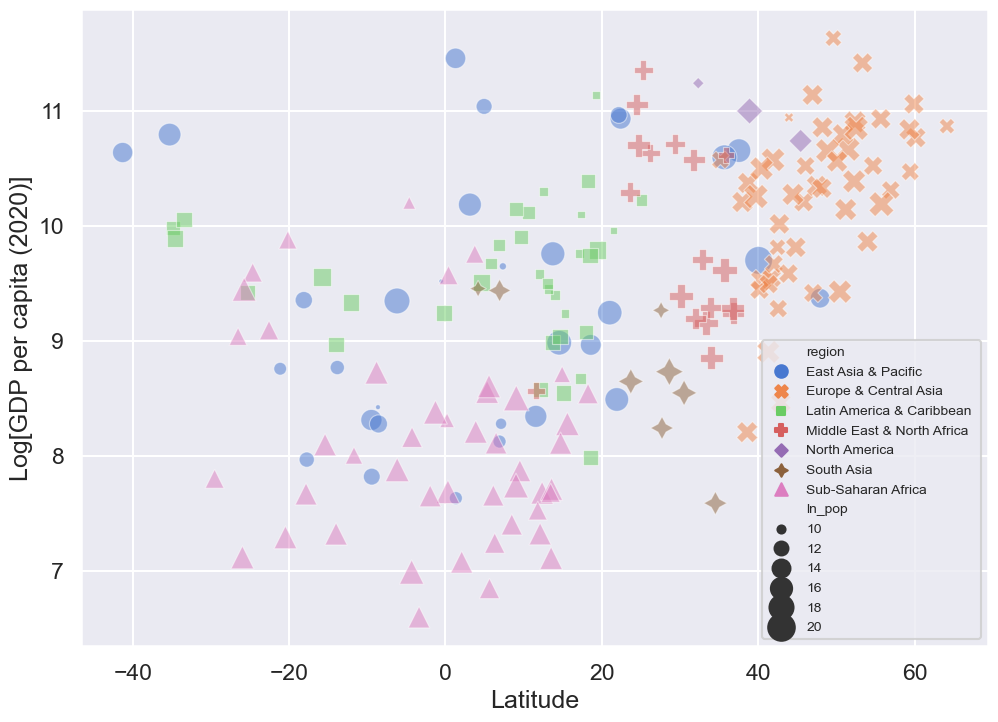

In [36]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_context("talk")

fig, ax = plt.subplots()
sns.scatterplot(x="latitude", 
                y="ln_gdp_pc", 
                data=dffig,
                hue="region",
                hue_order = dffig.region.drop_duplicates().sort_values(),
                style="region",
                style_order = dffig.region.drop_duplicates().sort_values(),
                size="ln_pop",
                sizes=(10, 400), 
                alpha=.5, 
                palette="muted",
                ax=ax
               )
ax.set_xlabel('Latitude')
ax.set_ylabel('Log[GDP per capita (' + str(year) + ')]')
ax.legend(fontsize=10)

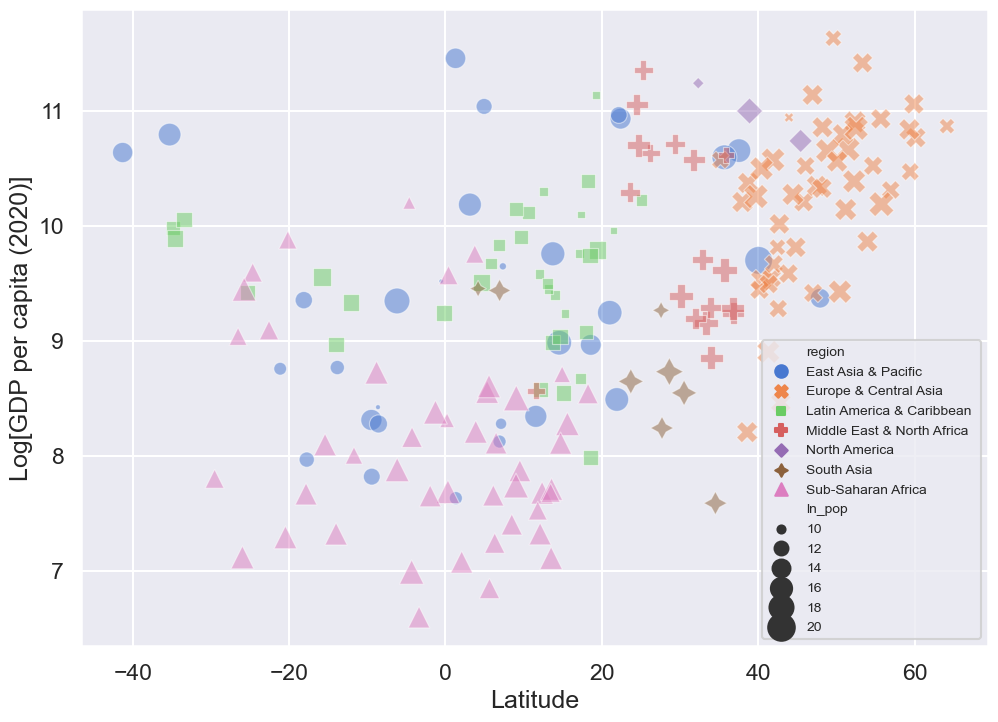

In [37]:
fig

# Based on **seaborn** we can create a useful functions that create plots for us
## E.g., scatter plots with labels, OLS regression lines, 45 degree lines, etc

In [38]:
def my_xy_plot(dfin, 
               x='SP.POP.GROW', 
               y='ln_gdp_pc', 
               labelvar='iso3c', 
               dx=0.006125, 
               dy=0.006125, 
               xlogscale=False, 
               ylogscale=False,
               xlabel='Growth Rate of Population', 
               ylabel='Log[Income per capita in ' +  str(year) + ']',
               labels=False,
               xpct = False,
               ypct = False,
               OLS=False,
               OLSlinelabel='OLS',
               ssline=False,
               sslinelabel='45 Degree Line',
               filename='income-pop-growth.pdf',
               hue='region',
               hue_order=['East Asia & Pacific', 'Europe & Central Asia',
                          'Latin America & Caribbean ', 'Middle East & North Africa',
                          'North America', 'South Asia', 'Sub-Saharan Africa '],
               style='incomeLevel', 
               style_order=['High Income', 'Upper Middle Income', 'Lower Middle Income', 'Low Income'],
               palette=None,
               size=None,
               sizes=None,
               legend_fontsize=10,
               label_font_size=12,
               save=True):
    '''
    Plot the association between x and var in dataframe using labelvar for labels.
    '''
    sns.set(rc={'figure.figsize':(11.7,8.27)})
    sns.set_context("talk")
    df = dfin.copy()
    df = df.dropna(subset=[x, y]).reset_index(drop=True)
    # Plot
    k = 0
    fig, ax = plt.subplots()
    sns.scatterplot(x=x, y=y, data=df, ax=ax, 
                    hue=hue,
                    hue_order=hue_order,
                    #hue='incomeLevel',
                    #hue_order=['High Income', 'Upper Middle Income', 'Lower Middle Income', 'Low Income'],
                    #hue_order=['East Asia & Pacific', 'Europe & Central Asia',
                    #           'Latin America & Caribbean ', 'Middle East & North Africa',
                    #           'North America', 'South Asia', 'Sub-Saharan Africa '],
                    alpha=1, 
                    style=style, 
                    style_order=style_order,
                    palette=palette,
                    size=size,
                    sizes=sizes,
                    #palette=sns.color_palette("Blues_r", df[hue].unique().shape[0]+6)[:df[hue].unique().shape[0]*2:2],
                )
    if OLS:
        sns.regplot(x=x, y=y, data=df, ax=ax, label=OLSlinelabel, scatter=False)
    if ssline:
        ax.plot([df[x].min()*.99, df[x].max()*1.01], [df[x].min()*.99, df[x].max()*1.01], c='r', label=sslinelabel)
    if labels:
        movex = df[x].mean() * dx
        movey = df[y].mean() * dy
        for line in range(0,df.shape[0]):
            ax.text(df[x][line]+movex, df[y][line]+movey, df[labelvar][line], horizontalalignment='left', fontsize=label_font_size, color='black')
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    if xpct:
        fmt = '%.0f%%' # Format you want the ticks, e.g. '40%'
        xticks = mtick.FormatStrFormatter(fmt)
        ax.xaxis.set_major_formatter(xticks)
    if ypct:
        fmt = '%.0f%%' # Format you want the ticks, e.g. '40%'
        yticks = mtick.FormatStrFormatter(fmt)
        ax.yaxis.set_major_formatter(yticks)
    if ylogscale:
        ax.set(yscale="log")
    if xlogscale:
        ax.set(xscale="log")
    handles, labels = ax.get_legend_handles_labels()
    handles = np.array(handles)
    labels = np.array(labels)
    handles = list(handles[(labels!=hue) & (labels!=style) & (labels!=size)])
    labels = list(labels[(labels!=hue) & (labels!=style) & (labels!=size)])
    ax.legend(handles=handles, labels=labels, fontsize=legend_fontsize)
    if save:
        plt.savefig(pathgraphs + filename, dpi=300, bbox_inches='tight')
    return fig

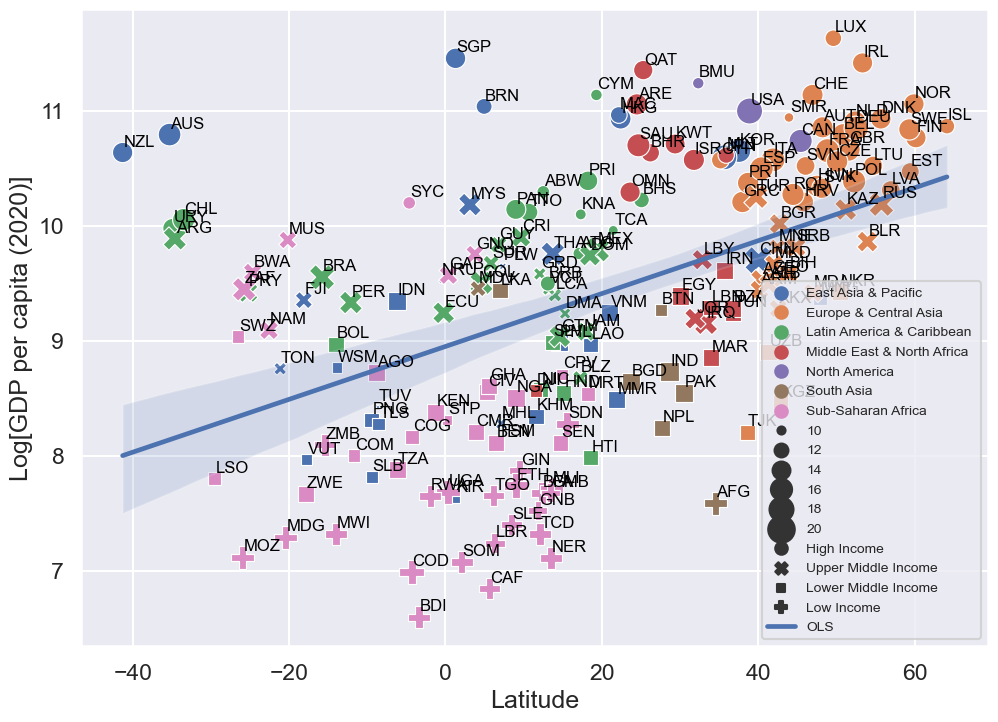

In [87]:
g = my_xy_plot(dffig, 
               x='latitude', 
               y='ln_gdp_pc', 
               xlabel='Latitude', 
               ylabel='Log[GDP per capita (' + str(year) +')]', 
               OLS=True, 
               labels=True, 
               size="ln_pop", 
               sizes=(10, 400), 
               filename='ln-gdp-pc-latitude.pdf')

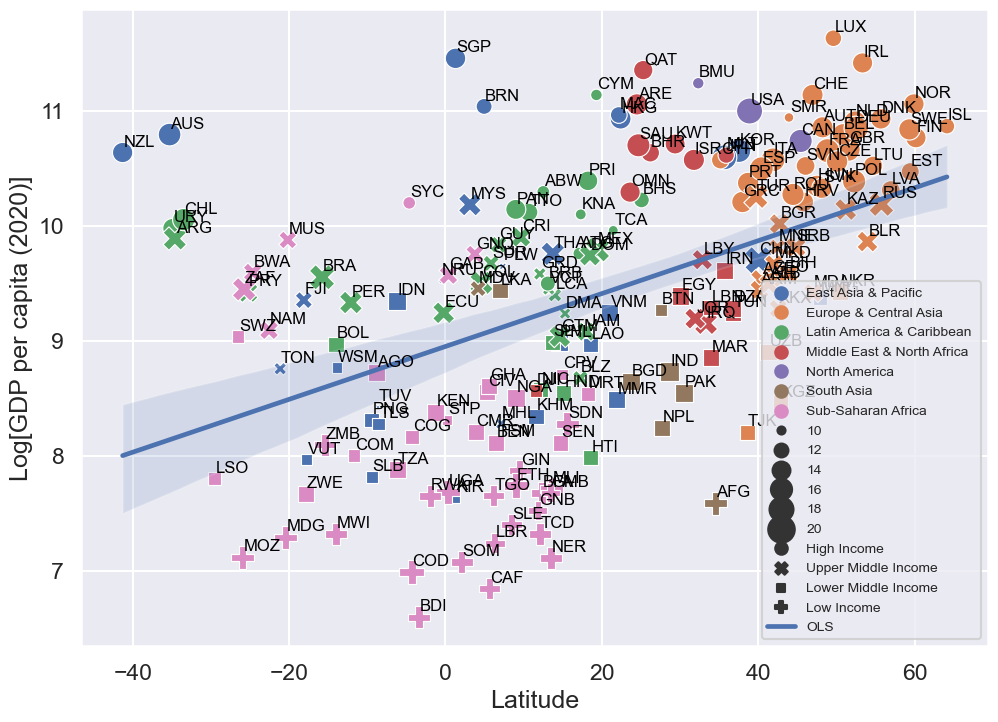

In [88]:
g

## Plot the evolution of variables across time by groups

In [41]:
def my_xy_line_plot(dfin, 
                    x='year', 
                    y='ln_gdp_pc', 
                    labelvar='iso3c', 
                    dx=0.006125, 
                    dy=0.006125, 
                    xlogscale=False, 
                    ylogscale=False,
                    xlabel='Growth Rate of Population', 
                    ylabel='Log[Income per capita in ' +  str(year) + ']',
                    labels=False,
                    xpct = False,
                    ypct = False,
                    OLS=False,
                    OLSlinelabel='OLS',
                    ssline=False,
                    sslinelabel='45 Degree Line',
                    filename='income-pop-growth.pdf',
                    hue='region',
                    hue_order=['East Asia & Pacific', 'Europe & Central Asia',
                               'Latin America & Caribbean ', 'Middle East & North Africa',
                               'North America', 'South Asia', 'Sub-Saharan Africa '],
                    style='incomeLevel', 
                    style_order=['High Income', 'Upper Middle Income', 'Lower Middle Income', 'Low Income'],
                    palette=None,
                    legend_fontsize=10,
                    label_fontsize=12,
                    loc=None,
                    save=True):
    '''
    Plot the association between x and var in dataframe using labelvar for labels. 
    '''
    sns.set(rc={'figure.figsize':(11.7,8.27)})
    sns.set_context("talk")
    df = dfin.copy()
    df = df.dropna(subset=[x, y]).reset_index(drop=True)
    # Plot
    k = 0
    fig, ax = plt.subplots()
    sns.lineplot(x=x, y=y, data=df, ax=ax, 
                    hue=hue,
                    hue_order=hue_order,
                    alpha=1, 
                    style=style, 
                    style_order=style_order,
                    palette=palette,
                )
    if OLS:
        sns.regplot(x=x, y=y, data=df, ax=ax, label=OLSlinelabel, scatter=False)
    if ssline:
        ax.plot([df[x].min()*.99, df[x].max()*1.01], [df[x].min()*.99, df[x].max()*1.01], c='r', label=sslinelabel)
    if labels:
        movex = df[x].mean() * dx
        movey = df[y].mean() * dy
        for line in range(0,df.shape[0]):
            ax.text(df[x][line]+movex, df[y][line]+movey, df[labelvar][line], horizontalalignment='left', fontsize=label_fontsize, color='black')
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    if xpct:
        fmt = '%.0f%%' # Format you want the ticks, e.g. '40%'
        xticks = mtick.FormatStrFormatter(fmt)
        ax.xaxis.set_major_formatter(xticks)
    if ypct:
        fmt = '%.0f%%' # Format you want the ticks, e.g. '40%'
        yticks = mtick.FormatStrFormatter(fmt)
        ax.yaxis.set_major_formatter(yticks)
    if ylogscale:
        ax.set(yscale="log")
    if xlogscale:
        ax.set(xscale="log")
    handles, labels = ax.get_legend_handles_labels()
    handles = np.array(handles)
    labels = np.array(labels)
    handles = list(handles[(labels!='region') & (labels!='incomeLevel')])
    labels = list(labels[(labels!='region') & (labels!='incomeLevel')])
    ax.legend(handles=handles, labels=labels, fontsize=legend_fontsize, loc=loc)
    if save:
        plt.savefig(pathgraphs + filename, dpi=300, bbox_inches='tight')
    return fig

## Log[GDP per capita across the world] by WB Income Groups

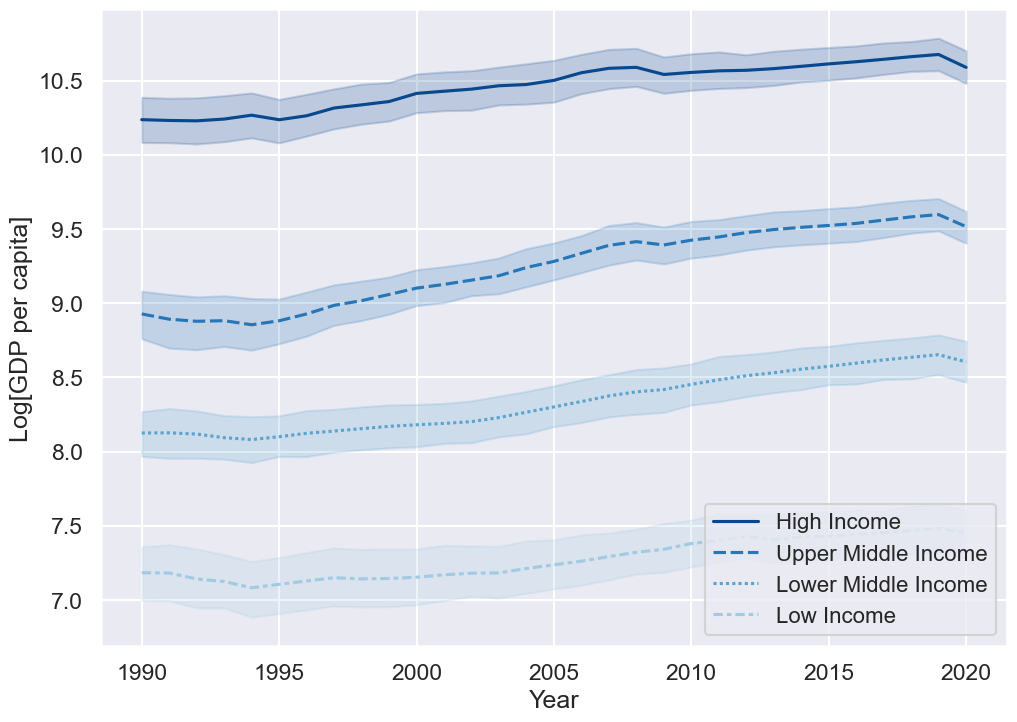

In [42]:
palette=sns.color_palette("Blues_r", wdi['incomeLevel'].unique().shape[0]+6)[:wdi['incomeLevel'].unique().shape[0]*2:2]
fig = my_xy_line_plot(wdi, 
                x='year', 
                y='ln_gdp_pc', 
                xlabel='Year',
                ylabel='Log[GDP per capita]',
                filename='ln-gdp-pc-income-groups-TS.pdf',
                hue='incomeLevel',
                hue_order=['High Income', 'Upper Middle Income', 'Lower Middle Income', 'Low Income'],
                palette=palette,
                OLS=False, 
                labels=False,
                legend_fontsize=16,
                loc='lower right',
                save=True)

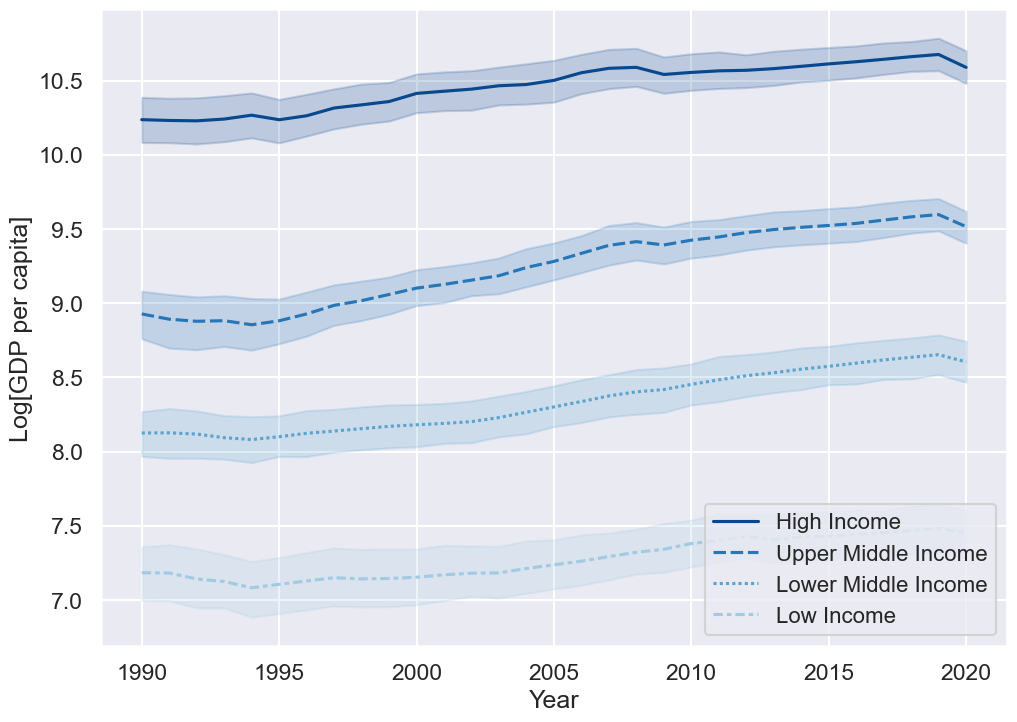

In [43]:
fig

## GDP per capita across the world by WB Regions

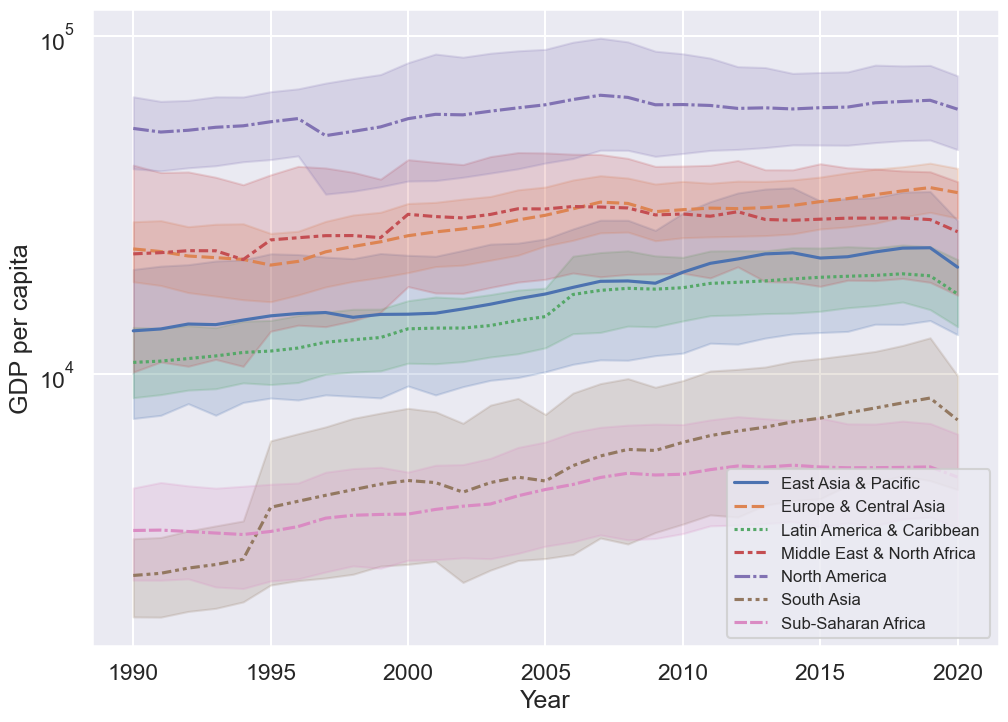

In [44]:
#palette=sns.color_palette("Blues_r", wdi['region'].unique().shape[0]+6)[:wdi['region'].unique().shape[0]*2:2]
fig = my_xy_line_plot(wdi, 
                      x='year', 
                      y='gdp_pc', 
                      xlabel='Year',
                      ylabel='GDP per capita',
                      ylogscale=True,
                      filename='ln-gdp-pc-regions-TS.pdf',
                      style='region',
                      style_order=['East Asia & Pacific', 'Europe & Central Asia',
                                   'Latin America & Caribbean ', 'Middle East & North Africa',
                                   'North America', 'South Asia', 'Sub-Saharan Africa '],
                      #palette=palette,
                      OLS=False, 
                      labels=False,
                      legend_fontsize=12,
                      loc='lower right',
                      save=True)

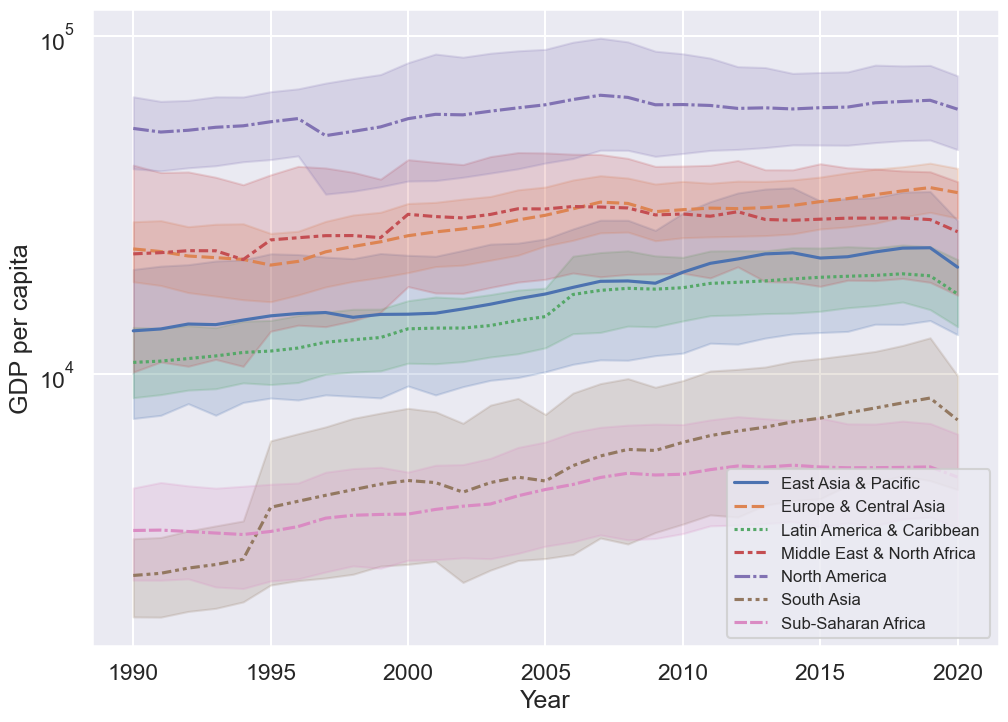

In [45]:
fig

# Plots with 
<center><a href="https://plotly.com/python/"><img src="https://raw.githubusercontent.com/SMU-Econ-Growth/EconGrowthUG-Notebooks/main/pics/plot_ly-ar21.svg" alt="plotly express" width=700/></a></center>

In [46]:
url = 'https://plotly.com/python/'
IFrame(url, width=800, height=400)

## Let's [select symbols to plot](https://plotly.com/python/marker-style/) so it looks like the previous ones and also to improve visibility

In [89]:
symbols = ['circle', 'x', 'square', 'cross', 'diamond', 'star-diamond', 'triangle-up']
fig = px.scatter(dffig,
                 x="latitude", 
                 y="ln_gdp_pc", 
                 color='region',
                 symbol='region',
                 symbol_sequence=symbols,
                 hover_name='name',
                 hover_data=['iso3c', 'ln_pop', 'gdp_pc'],
                 size='ln_pop',
                 size_max=15,
                 trendline="ols",
                 trendline_scope="overall",
                 trendline_color_override="black",
                 labels={
                     "latitude": "Latitude",
                     "ln_gdp_pc": "Log[GDP per capita (" + str(year) + ")]",
                     "gdp_pc": "GDP per capita (" + str(year) + ")",
                     "region": "WB Region"
                 },
                 opacity=0.75,
                 height=800,
                )

In [90]:
fig.show()

# Change marker borders

In [91]:
fig.update_traces(marker=dict(#size=12,
                              line=dict(width=2,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers'))

In [92]:
fig.show()

# Increase width of trend line

In [93]:
tr_line=[]
for  k, trace  in enumerate(fig.data):
        if trace.mode is not None and trace.mode == 'lines':
            tr_line.append(k)
print(tr_line)
for id in tr_line:
    fig.data[id].update(line_width=3)

[7]


In [94]:
fig.show()

# Change legend position

In [97]:
fig.update_layout(legend=dict(
    yanchor="top",
    y=0.25,
    xanchor="left",
    x=0.9
))

In [98]:
fig.show()

# To save the figure use in your desired format
```python
fig.write_image(pathgraphs + "fig1.pdf")
fig.write_image(pathgraphs + "fig1.png")
fig.write_image(pathgraphs + "fig1.jpg")
```

In [55]:
fig.write_image(pathgraphs + "ln-gdp-pc-latitude-plotly.pdf", height=1000, width=1500, scale=4)

## We can access the results of the regression in **plotly express**

In [56]:
results = px.get_trendline_results(fig)
results.px_fit_results.iloc[0].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.234
Model:                            OLS   Adj. R-squared:                  0.230
Method:                 Least Squares   F-statistic:                     57.42
Date:                Thu, 27 Oct 2022   Prob (F-statistic):           1.55e-12
Time:                        11:33:08   Log-Likelihood:                -270.26
No. Observations:                 190   AIC:                             544.5
Df Residuals:                     188   BIC:                             551.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.9496      0.092     97.348      0.000       8.768       9.131
x1             0.0230      0.003      7.578      0.000       0.017       0.029
==============================================================================
Omnibus:                        0.797   Durbin-Watson:                   1.678
Prob(Omnibus):                  0.671   Jarque-Bera (JB):                0.853
Skew:                           0.002   Prob(JB):                        0.653
Kurtosis:                       2.672   Cond. No.                         38.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Maps with
<center><a href="https://seaborn.pydata.org/index.html#"><img src="https://raw.githubusercontent.com/SMU-Econ-Growth/EconGrowthUG-Notebooks/main/pics/logo-wide-lightbg.svg" alt="seaborn" width=700/></a></center>

# To create maps we need to obtain *geographical information*

There are various types of data in **Geographic Information Systems (GIS)**

* Location of cities, resources, etc. (point data)

* Shape of rivers, borders, countries, etc. (shape data)

* Numerical data for locations (elevation, temperature, number of people)

## Download Country boundary data from [Natural Earth](http://www.naturalearthdata.com/)

In [57]:
headers = {'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/51.0.2704.103 Safari/537.36', 'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8'}

url = 'https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/10m/cultural/ne_10m_admin_0_countries.zip'
r = requests.get(url, headers=headers)
countries = gp.read_file(io.BytesIO(r.content))

In [100]:
countries.head()

featurecla  scalerank  LABELRANK SOVEREIGNT SOV_A3  ADM0_DIF  LEVEL               TYPE TLC      ADMIN  ... FCLASS_TR  FCLASS_ID FCLASS_PL FCLASS_GR  FCLASS_IT FCLASS_NL  \
0  Admin-0 country          0          2  Indonesia    IDN         0      2  Sovereign country   1  Indonesia  ...      None       None      None      None       None      None   
1  Admin-0 country          0          3   Malaysia    MYS         0      2  Sovereign country   1   Malaysia  ...      None       None      None      None       None      None   
2  Admin-0 country          0          2      Chile    CHL         0      2  Sovereign country   1      Chile  ...      None       None      None      None       None      None   
3  Admin-0 country          0          3    Bolivia    BOL         0      2  Sovereign country   1    Bolivia  ...      None       None      None      None       None      None   
4  Admin-0 country          0          2       Peru    PER         0      2  Sovereign country   1       Peru  ...      None       None      None      None       None      None   

  FCLASS_SE  FCLASS_BD FCLASS_UA                                           geometry  
0      None       None      None  MULTIPOLYGON (((117.70361 4.16341, 117.70361 4...  
1      None       None      None  MULTIPOLYGON (((117.70361 4.16341, 117.69711 4...  
2      None       None      None  MULTIPOLYGON (((-69.51009 -17.50659, -69.50611...  
3      None       None      None  POLYGON ((-69.51009 -17.50659, -69.51009 -17.5...  
4      None       None      None  MULTIPOLYGON (((-69.51009 -17.50659, -69.63832...  

[5 rows x 169 columns]

## The boundary file is a **geopandas** dataframe

Text(0.5, 1.0, 'WGS84 (lat/lon)')

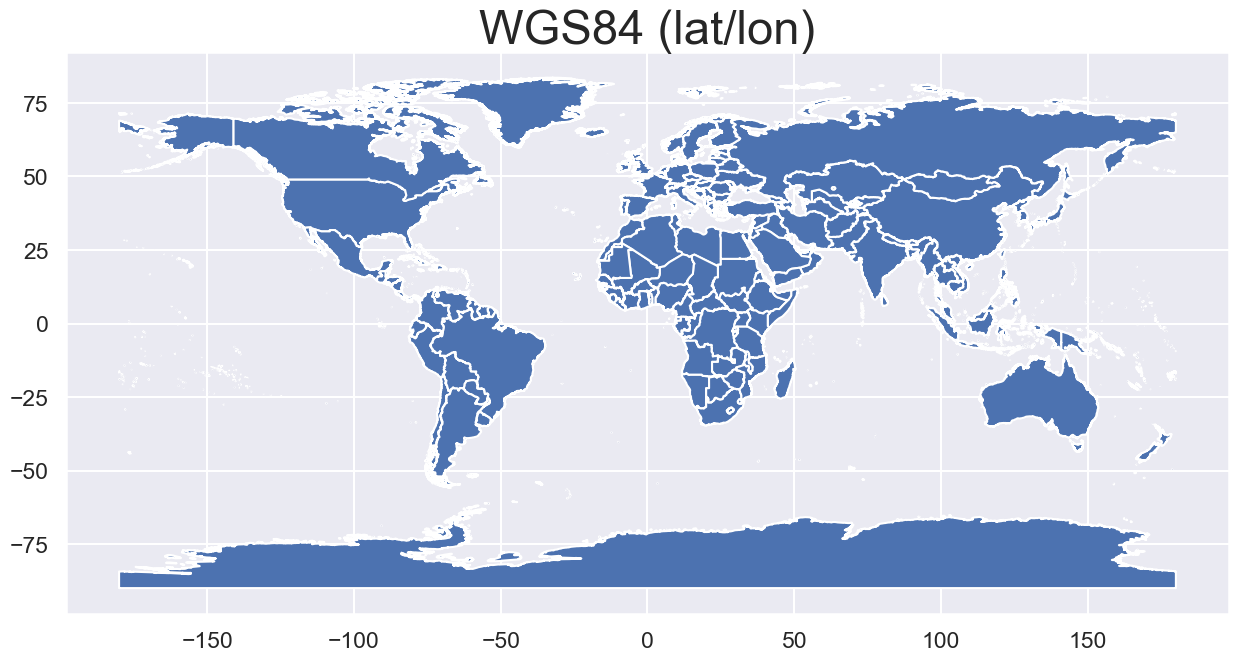

In [58]:
fig, ax = plt.subplots(figsize=(15,10))
countries.plot(ax=ax)
ax.set_title("WGS84 (lat/lon)", fontdict={'fontsize':34})

## Merge with other data and plot

In [59]:
dffig2 = countries.merge(dffig, left_on='ADM0_A3', right_on='iso3c')

Text(0.5, 1.0, 'WGS84 (lat/lon)')

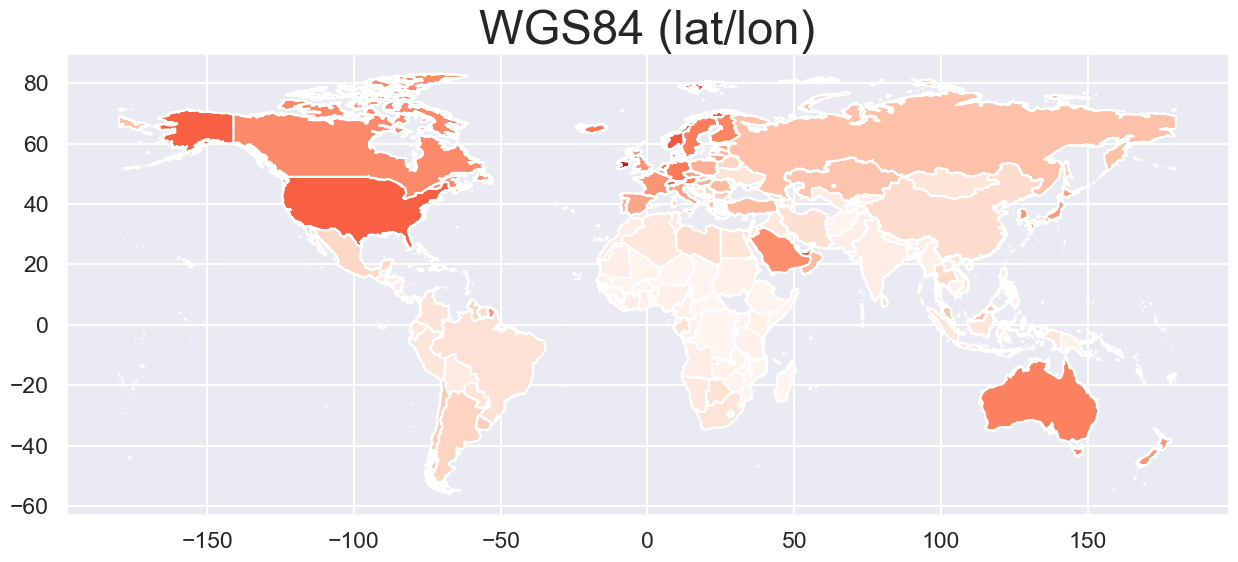

In [60]:
fig, ax = plt.subplots(figsize=(15,10))
dffig2.plot(column='gdp_pc', ax=ax, cmap='Reds')
ax.set_title("WGS84 (lat/lon)", fontdict={'fontsize':34})

# Maps with [geoplot](https://residentmario.github.io/geoplot/)

In [61]:
url = 'https://residentmario.github.io/geoplot/'
IFrame(url, width=800, height=400)

# Plot Countries

<GeoAxesSubplot:>

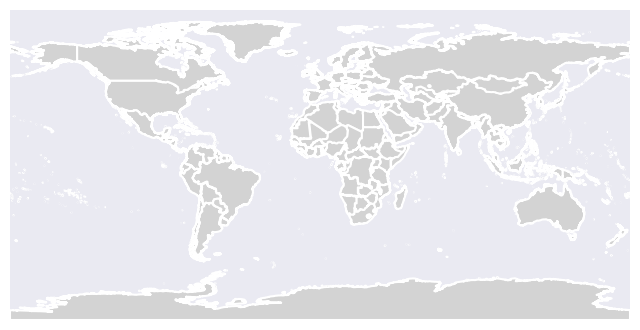

In [102]:
gplt.polyplot(
    countries, projection=gcrs.PlateCarree(central_longitude=0.0, globe=None),
    edgecolor='white', facecolor='lightgray',
    rasterized=True,
    extent=[-180, -90, 180, 90],
)

# Plot Data

<GeoAxesSubplot:>

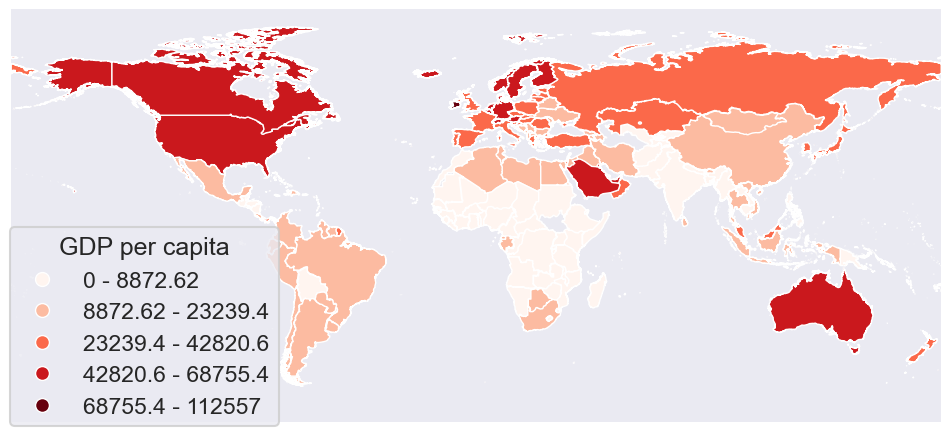

In [63]:
gplt.choropleth(dffig2, hue='gdp_pc', 
                projection=gcrs.PlateCarree(central_longitude=0.0, globe=None),
                edgecolor='white', 
                linewidth=1,
                cmap='Reds', legend=True,
                scheme='FisherJenks',
                legend_kwargs={'bbox_to_anchor':(0.3, 0.5),
                               'frameon': True,
                               'title':'GDP per capita',
                              },
                figsize=(12,8),
                rasterized=True,
               )

# Data and Borders

<GeoAxesSubplot:>

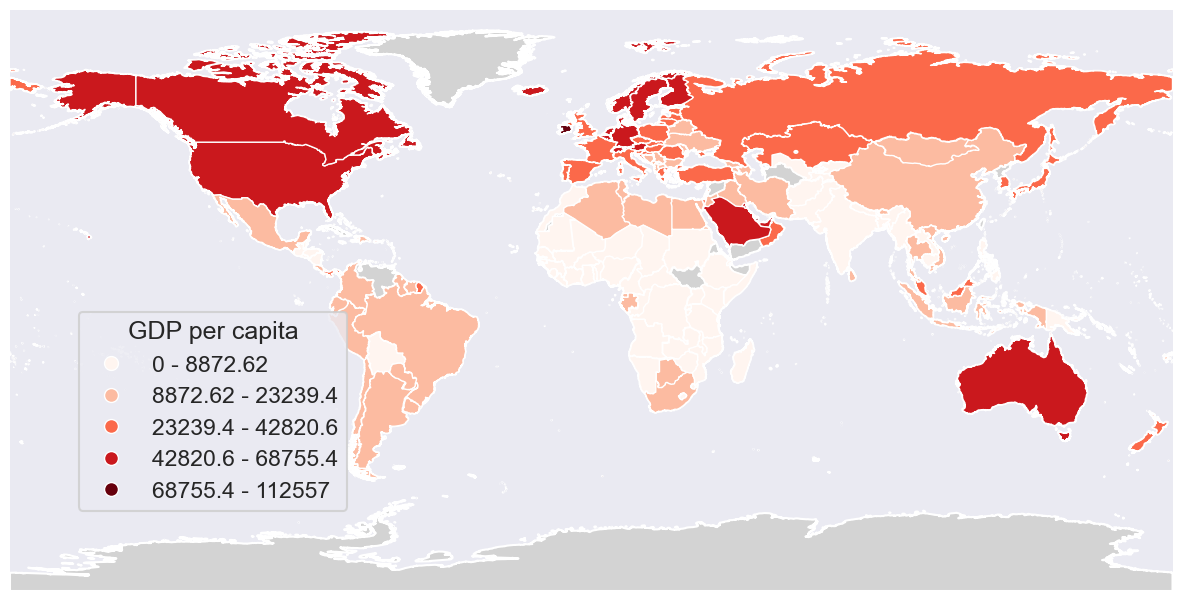

In [64]:
ax = gplt.choropleth(dffig2, hue='gdp_pc', projection=gcrs.PlateCarree(central_longitude=0.0, globe=None),
                     edgecolor='white', linewidth=1,
                     cmap='Reds', legend=True,
                     scheme='FisherJenks',
                     legend_kwargs={'bbox_to_anchor':(0.3, 0.5),
                                    'frameon': True,
                                    'title':'GDP per capita',
                                   },
                     figsize=(15,10),
                     rasterized=True,
                    )
gplt.polyplot(countries, projection=gcrs.PlateCarree(central_longitude=0.0, globe=None),
              edgecolor='white', facecolor='lightgray',
              ax=ax,
              rasterized=True,
              extent=[-180, -90, 180, 90],
             )

# Use a nice function

In [65]:
# Functions for plotting
def center_wrap(text, cwidth=32, **kw):
    '''Center Text (to be used in legend)'''
    lines = text
    #lines = textwrap.wrap(text, **kw)
    return "\n".join(line.center(cwidth) for line in lines)

def MyChloropleth(mydf, myfile='fig', myvar='gdp_pc',
                  mylegend='GDP per capita',
                  k=5,
                  extent=[-180, -90, 180, 90],
                  bbox_to_anchor=(0.2, 0.5),
                  edgecolor='white', facecolor='lightgray',
                  scheme='FisherJenks',
                  save=True,
                  percent=False,
                  **kwargs):
    # Chloropleth
    # Color scheme
    if scheme=='EqualInterval':
        scheme = mc.EqualInterval(mydf[myvar], k=k)
    elif scheme=='Quantiles':
        scheme = mc.Quantiles(mydf[myvar], k=k)
    elif scheme=='BoxPlot':
        scheme = mc.BoxPlot(mydf[myvar], k=k)
    elif scheme=='FisherJenks':
        scheme = mc.FisherJenks(mydf[myvar], k=k)
    elif scheme=='FisherJenksSampled':
        scheme = mc.FisherJenksSampled(mydf[myvar], k=k)
    elif scheme=='HeadTailBreaks':
        scheme = mc.HeadTailBreaks(mydf[myvar], k=k)
    elif scheme=='JenksCaspall':
        scheme = mc.JenksCaspall(mydf[myvar], k=k)
    elif scheme=='JenksCaspallForced':
        scheme = mc.JenksCaspallForced(mydf[myvar], k=k)
    elif scheme=='JenksCaspallSampled':
        scheme = mc.JenksCaspallSampled(mydf[myvar], k=k)
    elif scheme=='KClassifiers':
        scheme = mc.KClassifiers(mydf[myvar], k=k)
    # Format legend
    upper_bounds = scheme.bins
    # get and format all bounds
    bounds = []
    for index, upper_bound in enumerate(upper_bounds):
        if index == 0:
            lower_bound = mydf[myvar].min()
        else:
            lower_bound = upper_bounds[index-1]
        # format the numerical legend here
        if percent:
            bound = f'{lower_bound:.0%} - {upper_bound:.0%}'
        else:
            bound = f'{float(lower_bound):,.0f} - {float(upper_bound):,.0f}'
        bounds.append(bound)
    legend_labels = bounds
    #Plot
    ax = gplt.choropleth(
        mydf, hue=myvar, projection=gcrs.PlateCarree(central_longitude=0.0, globe=None),
        edgecolor='white', linewidth=1,
        cmap='Reds', legend=True,
        scheme=scheme,
        legend_kwargs={'bbox_to_anchor': bbox_to_anchor,
                       'frameon': True,
                       'title':mylegend,
                       },
        legend_labels = legend_labels,
        figsize=(24, 16),
        rasterized=True,
    )
    gplt.polyplot(
        countries, projection=gcrs.PlateCarree(central_longitude=0.0, globe=None),
        edgecolor=edgecolor, facecolor=facecolor,
        ax=ax,
        rasterized=True,
        extent=extent,
    )
    if save:
        plt.savefig(pathgraphs + myfile + '.pdf', dpi=300, bbox_inches='tight')
        plt.savefig(pathgraphs + myfile + '.png', dpi=300, bbox_inches='tight')
    pass

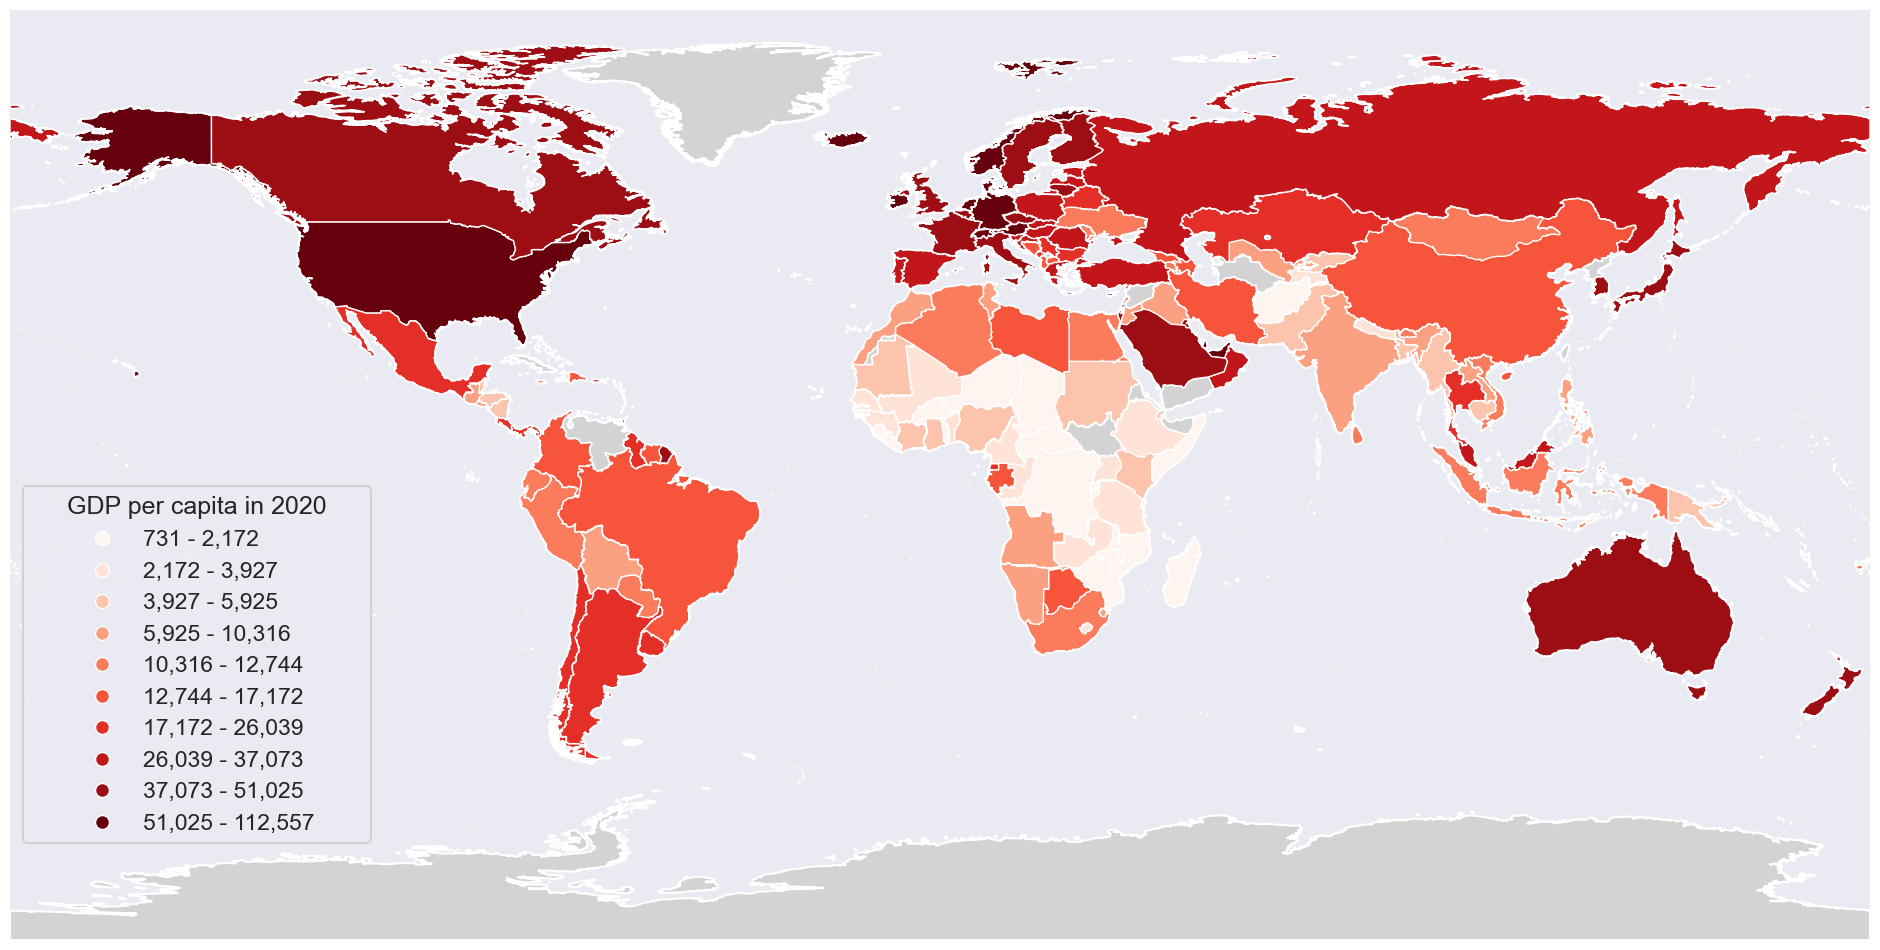

In [66]:
mylegend = center_wrap(["GDP per capita in " + str(year)], cwidth=32, width=32)
MyChloropleth(dffig2, myfile='fig-gdp-pc-' + str(year), myvar='gdp_pc', mylegend=mylegend, k=10, scheme='Quantiles', save=True)

# Quick and Easy Maps with
<center><a href="https://plotly.com/python/"><img src="https://raw.githubusercontent.com/SMU-Econ-Growth/EconGrowthUG-Notebooks/main/pics/plot_ly-ar21.svg" alt="plotly express" width=700/></a></center>

In [67]:
url = 'https://plotly.com/python/maps/'
IFrame(url, width=800, height=400)

# Map using classes (similar to **geoplot**)

## Choose a classifier and classify the data

In [68]:
scheme = mc.Quantiles(dffig2['gdp_pc'], k=5)
classifier = mc.Quantiles.make(k=5, rolling=True)
dffig2['gdp_pc_q'] = classifier(dffig2['gdp_pc'])
dffig2['gdp_pc_qc'] = dffig2['gdp_pc_q'].apply(lambda x: scheme.get_legend_classes()[x].replace('[   ', '[').replace('( ', '('))

In [69]:
fig = px.choropleth(dffig2.sort_values('gdp_pc_q', ascending=True), 
                    locations="iso3c",
                    color="gdp_pc_qc",
                    hover_name='name',
                    hover_data=['iso3c', 'ln_pop'],
                    labels={
                        "gdp_pc_qc": "GDP per capita (" + str(year) + ")",
                    },
                    color_discrete_sequence=px.colors.sequential.Reds,
                    height=600, 
                    width=1000,
                   )
# Change legend position
fig.update_layout(legend=dict(
    yanchor="bottom",
    y=0.15,
    xanchor="left",
    x=0.05
))

In [70]:
fig.show()

In [71]:
fig = px.choropleth(dffig2.sort_values('gdp_pc_q', ascending=True), 
                    locations="iso3c",
                    color="gdp_pc_qc",
                    hover_name='name',
                    hover_data=['iso3c', 'gdp_pc' ,'ln_pop'],
                    labels={
                        "gdp_pc_qc": "GDP per capita (" + str(year) + ")",
                        "gdp_pc": "GDP per capita (" + str(year) + ")",
                        'iso3c':'ISO code',
                        "ln_pop": "Log[Population (" + str(year) + ")]",
                    },
                    color_discrete_sequence=px.colors.sequential.Blues,
                    height=600, 
                    width=1000,
                   )
# Change legend position
fig.update_layout(legend=dict(
    yanchor="bottom",
    y=0.15,
    xanchor="left",
    x=0.05
))

In [72]:
fig.show()

In [73]:
fig = px.choropleth(dffig, 
                    locations="iso3c",
                    color="ln_gdp_pc",
                    hover_name='name',
                    hover_data=['iso3c', 'ln_pop'],
                    labels={
                        "ln_gdp_pc": "Log[GDP per capita (" + str(year) + ")]",
                    },
                    #color_continuous_scale=px.colors.sequential.Plasma,
                    color_continuous_scale="Reds",
                    height=600, 
                    width=1100,
                   )

In [74]:
fig.show()

In [75]:
fig.update_layout(coloraxis_colorbar=dict(
    orientation = 'h',
    yanchor="bottom", 
    xanchor="left", 
    y=-.2,
    x=0,
))
fig.update_coloraxes(colorbar_title_side='top')

In [76]:
fig.show()

In [77]:
# Change legend position
fig.update_layout(legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="center",
    x=0.01,
    orientation='h',
))

In [78]:
fig.show()

In [79]:
fig = go.Figure(data=go.Choropleth(
    locations = dffig['iso3c'],
    z = dffig['gdp_pc'],
    text = dffig['name'],
    colorscale = 'Blues',
    autocolorscale=False,
    reversescale=True,
    marker_line_color='darkgray',
    marker_line_width=0.5,
    colorbar_tickprefix = '$',
    colorbar_title = 'GDP pc',
    )                  
)
fig.update_layout(
    autosize=False,
    width=800,
    height=400,
    margin=dict(
        l=5,
        r=5,
        b=10,
        t=10,
        pad=1
    ),
    paper_bgcolor="LightSteelBlue",
)

In [80]:
fig.show()

In [81]:
fig = go.Figure(data=go.Choropleth(
    locations = dffig['iso3c'],
    z = dffig['gdp_pc'],
    text = dffig['name'],
    colorscale = 'Blues',
    autocolorscale=False,
    reversescale=True,
    marker_line_color='darkgray',
    marker_line_width=0.5,
    colorbar_tickprefix = '$',
    colorbar_title = 'GDP per capita',
    )                  
)
fig.update_layout(
    autosize=False,
    width=1000,
    height=600,
    margin=dict(
        l=1,
        r=1,
        b=1,
        t=1,
        pad=.1
    ),
    paper_bgcolor="LightSteelBlue",
)
# Change legend position
cb = fig.data[0].colorbar
cb.orientation = 'h'
cb.yanchor = 'bottom'
cb.xanchor = 'center'
cb.y = .1
cb.title.side = 'top'

In [82]:
fig.show()

# <center>Exercises</center>

<div class="alert alert-block alert-warning">
    <b>Exercise 1:</b> Get WDI data on <b>patent applications by residents and non-residents in each country</b>. Create a new variable that shows the total patents for each country.
</div>

<div class="alert alert-block alert-warning">
<b>Exercise 2:</b> Using the <code>my_xy_plot</code> function plot the relation between <b>GDP per capita</b> and <b>total patents</b> in the years 1990, 1995, 2000, 2010, 2020.
</div>

<div class="alert alert-block alert-warning">
<b>Exercise 3:</b> Using the <code>my_xy_line_plot</code> function plot the evolution of <b>GDP per capita</b> and <b>total patents</b> by income groups and regions (separate figures).
</div>

<div class="alert alert-block alert-warning">
<b>Exercise 4:</b> Plot the relation between patenting activity by <b>residents and non-residents</b> in the year 2015. Make sure to show the 45 degree line so you can see how similar they are.
</div>

<div class="alert alert-block alert-warning">
<b>Exercise 5:</b> Create a static and a dynamic map for patenting activity in the year 2015 across the world. 
</div>

<div class="alert alert-block alert-warning">
<b>Exercise 6:</b> Explore the relation between economic development as measured by Log[GDP per capita] and patenting activity. Show the relation for residents, non-residents, and total, all in one nice looking table. Also, produce a few nice looking figures.
</div>

Notebook written by [Ömer Özak](http://omerozak.com) for his students in Economics at [Southern Methodist University](http://www.smu.edu). Feel free to use, distribute, or contribute.

[<center><img src="https://github.com/measuring-culture/Expanding-Measurement-Culture-Facebook-JRSI/blob/main/pics/SMUlogowWordmarkRB.jpg?raw=true" width="250"></center>](http://omerozak.com)